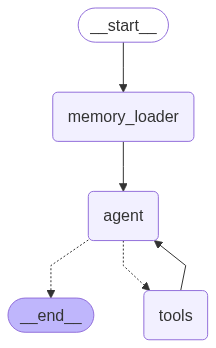

In [4]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from state.state import AgentState
from IPython.display import display, Image
from memory import TravelAgentMemory, MongoDBChatMessageHistory
from prompts.system import SYSTEM_PROMPT
from langchain_core.runnables.graph import MermaidDrawMethod
import uuid
from typing import Dict

# Import your tools
from tools.booking_tool import booking_lookup_tool, booking_create_tool, payment_update_tool
from tools.faq_tool import faq_tool
from tools.search_tools import search_tool, hotel_search_tool, flight_search_tool


llm = ChatOpenAI(
    model="gpt-3.5-turbo"
)

# Set up memory
travel_memory = TravelAgentMemory()

# Define all tools
tools = [
    booking_lookup_tool,
    booking_create_tool, 
    payment_update_tool,
    faq_tool,
    search_tool,
    hotel_search_tool,
    flight_search_tool
]


llm_with_tools = llm.bind_tools(tools=tools)

# Global memory instances for session management
user_memories: Dict[str, TravelAgentMemory] = {}

def get_or_create_memory(session_id: str) -> TravelAgentMemory:
    """Get existing memory or create new one for session."""
    if session_id not in user_memories:
        user_memories[session_id] = travel_memory
    return user_memories[session_id]

def memory_loader(state: AgentState) -> AgentState:
    """Load memory context with summaries and user data."""
    session_id = state.get("session_id") or str(uuid.uuid4())
    
    # Skip memory loading for first message
    if len(state["messages"]) <= 1:
        return {
            **state,
            "session_id": session_id,
            "memory_context": None,
            "user_preferences": {},
            "booking_history": []
        }
    
    # Get memory instance
    memory = get_or_create_memory(session_id)
    
    # Get latest user message for context
    latest_message = state["messages"][-1]
    query = latest_message.content if hasattr(latest_message, 'content') else ""
    
    # Load comprehensive memory context
    memory_context = memory.recall_with_summary(session_id, query)
    user_preferences = memory.get_user_preferences(session_id)
    booking_history = memory.get_booking_history(session_id)
    
    return {
        **state,
        "session_id": session_id,
        "memory_context": memory_context,
        "user_preferences": user_preferences,
        "booking_history": booking_history
    }

def chatbot_with_memory(state: AgentState) -> AgentState:
    """Enhanced chatbot with comprehensive memory integration."""
    messages = state["messages"]
    session_id = state.get("session_id")
    memory_context = state.get("memory_context")
    user_preferences = state.get("user_preferences", {})
    booking_history = state.get("booking_history", [])
    
    # Get memory instance
    memory = get_or_create_memory(session_id)
    
    # Build enhanced system prompt with memory context
    enhanced_prompt = SYSTEM_PROMPT
    
    if memory_context or user_preferences or booking_history:
        memory_info = f"""

**MEMORY CONTEXT FOR PERSONALIZED ASSISTANCE:**

**Conversation Summary:**
{memory_context.get('conversation_summary', 'No previous conversation summary available.')}

**User Preferences:**
{user_preferences if user_preferences else 'No preferences stored yet.'}

**Booking History:**
- Total Bookings: {len(booking_history)}
- Recent Bookings: {booking_history[:3] if booking_history else 'No previous bookings found.'}

**Recent Conversation Context:**
- Previous Interactions: {len(memory_context.get('recent_conversations', []))} recent conversations
- Relevant Facts: {len(memory_context.get('travel_facts', []))} travel-related facts stored

**Instructions:**
Use this context to provide personalized assistance. Reference previous conversations, preferences, and booking patterns when relevant. Be conversational and acknowledge returning users appropriately.
"""
        enhanced_prompt += memory_info
    
    # Prepare messages with enhanced system prompt
    if not messages or not isinstance(messages[0], SystemMessage):
        messages = [SystemMessage(content=enhanced_prompt)] + messages
    else:
        # Update existing system message with memory context
        messages = [SystemMessage(content=enhanced_prompt)] + messages[1:]
    
    # Get LLM response
    response = llm_with_tools.invoke(messages)
    
    # Store conversation in memory with summarization check
    if session_id:
        # Store the user message and AI response
        conversation_messages = [messages[-1], response]  # Last user message + AI response
        memory.remember(session_id, conversation_messages)
        
        # Check if we need to create a summary (every 10 interactions)
        memory.store_conversation_summary(session_id, conversation_messages, summary_threshold=10)
    
    return {"messages": [response]}

def should_continue(state: AgentState):
    """Check if we should continue to tools or end the conversation."""
    messages = state.get("messages", [])
    if not messages:
        return END
    
    last_message = messages[-1]
    
    # Check if model wants to use tools
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        print(f"🔧 Using tools: {[tool.get('name', 'unknown') for tool in last_message.tool_calls]}")
        return "tools"
    
    return END




tool_node = ToolNode(tools=tools)


# Create the graph with memory integration
graph = StateGraph(AgentState)

# Add nodes
graph.add_node("memory_loader", memory_loader)
graph.add_node("agent", chatbot_with_memory)
graph.add_node("tools", ToolNode(tools))

# Define edges
graph.add_edge(START, "memory_loader")
graph.add_edge("memory_loader", "agent")
graph.add_edge("tools", "agent")

graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        END: END
    }
)

# Compile the graph
app = graph.compile()

def visualize_graph():
    """Visualize the state graph using Mermaid."""
    display(
        Image(
            app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
         )
        )
    )

visualize_graph()    